<a href="https://colab.research.google.com/github/densen1978/Capstone-project/blob/main/Capstone_Customers_segmentation_and_probability_of_purchase_with_Python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**CUSTOMERS CLUSTERING AND PROBABILITY TO PURCHASE ANALYSIS**

##**Capstone project**

###Objectives:

2. Segment customers (performed in SQL)
3. Create a statistical model to estimate a probability of purchase

###Dataset description
Company Google analytics dataset which provides the customers' information about their behaviour on the website and acquisition sources. It includes over 243,297 records and 55 attributes.

####**Variables:**
* channelGrouping (Nominal)
* date (Continuous)
* fullVisitorId (Continuous)
* sessionId (Continuous)
* socialEngagementType (Nominal)
* visitId (Continuous)
* visitNumber (Continuous)
* visitStartTime (Continuous)
* device.browser (Nominal)
* device.browserSize (Nominal)
* device.browserVersion (Continuous)
* device.deviceCategory (Nominal)
* device.flashVersion (Continuous)
* device.isMobile (Binary)
* device.language (Nominal)
* device.mobileDeviceBranding (Nominal)
* device.mobileDeviceInfo (Nominal)
* device.mobileDeviceMarketingName (Nominal)
* device.mobileDeviceModel (Nominal)
* device.mobileInputSelector (Nominal)
* device.operatingSystem (Nominal)
* device.operatingSystemVersion (Continuous)
* device.screenColors (Continuous)
* device.screenResolution (Continuous)
* geoNetwork.city (Continuous)
* geoNetwork.cityId (Nominal)
* geoNetwork.continent (Continuous)
* geoNetwork.country (Continuous)
* geoNetwork.latitude (Nominal)
* geoNetwork.longitude (Nominal)
* geoNetwork.metro (Continuous)
* geoNetwork.networkDomain (Continuous)
* geoNetwork.networkLocation (Continuous)
* geoNetwork.region (Continuous)
* geoNetwork.subContinent (Continuous)
* totals.bounces (Nominal)
* totals.hits (Nominal)
* totals.newVisits (Nominal)
* totals.pageviews (Nominal)
* totals.transactionRevenue (Nominal)
* totals.visits (Nominal)
* trafficSource.adContent (Continuous)
* trafficSource.adwordsClickInfo.adNetworkType (Continuous)
* trafficSource.adwordsClickInfo.criteriaParameters (Continuous)
* trafficSource.adwordsClickInfo.gclId (Nominal)
* trafficSource.adwordsClickInfo.isVideoAd (Binary)
* trafficSource.adwordsClickInfo.page (Continuous)
* trafficSource.adwordsClickInfo.slot (Continuous)
* trafficSource.campaign (Continuous)
* trafficSource.campaignCode (Continuous)
* trafficSource.isTrueDirect (Binary)
* trafficSource.keyword (Continuous)
* trafficSource.medium (Continuous)
* trafficSource.referralPath (Continuous)
* trafficSource.source (Continuous)
Predict variable (desired target)
* has_purchase (calculated based on the presence of transactional revenue - binary: “1”, means “Yes”, “0” means “No”)

Source: https://www.kaggle.com/datasets/colinpearse/ga-analytics-with-json-columns?select=newtrain.csv



## Table of Contents
* [0. Initialization](#0-initialization)
* [1. Exploratory Data Analysis (EDA)](#1-exploratory-data-analysis-eda)
    * [1.1 Variables analysis and preparation](#11-variables-analysis-and-preparation)
    * [1.2 Multicolinearity of variables and their correlation with target variable](#12-multicolinearity-of-variables-and-their-correlation-with-target-variable)
    * [1.3 Outliers](#13-outliers)
* [2. Model Creation](#2-model-creation)
    * [2.1 Logistic Regression Model](#23-logistic-regression-model)
* [3. Model Application in Practice](#3-model-application-in-practice)
    * [3.1 Model's threshold](#31-models-threshold)
    * [3.2 ROC Curve and AUC](#32-roc-curve-and-auc)
    * [3.3 Probability of purchase](#33-probability-of-purcchase)
* [4. Insights and recommendations](#4-insights-and-recommendations)

##0. Initialization
Importing necessary libraries for calculations and visualization

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import statsmodels.api as sm
from scipy.stats import mstats
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, confusion_matrix, classification_report
print("Setup Complete")

Setup Complete


Opening data CSV file

In [ ]:
# Set display options to prevent scientific notation
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Importing data from BigQuery
from google.cloud import bigquery
from google.colab import auth

auth.authenticate_user()
print('Authenticated')

project_id = 'my-project-sprint-1'
dataset_id = 'capstone'
table_id = 'capstone_campaign_modified_data'

# Initialize a BigQuery client
client = bigquery.Client(project=project_id)

# Construct a reference to the table
table_ref = client.dataset(dataset_id).table(table_id)

# Construct a query
query = f"""
    SELECT *
    FROM `{project_id}.{dataset_id}.{table_id}`
"""

# Send the query and get the results as a DataFrame
data = client.query(query).to_dataframe()



Authenticated


## 1. Exploratory Data Analysis (EDA)

Exploratory Data Analysis (EDA) - investigation and familiarization of the data. The goal of EDA is to understand the data, generate first insights & questions.
For example, we can ask ourselves such questions:
* Are the column names understandable? Are they too long? Are there duplicated names?
* Are there missing values? How best to clean them (if there's alot of missing values in each column and our dataset is small, removing them might not be the best option)?
* What are the value counts?
* Are the data values understandable? Do we need to convert or encode them?

Reading the file and splitting data into training and testing datasets

**EDA steps:**

1. Understanding the dataset, for example: head, tail, shape, info, describe.<br>
2. Cleaning, for example: .isduplicated(), .duplicated().<br>
3. Univariate analysis is the deep dive into the variables of interest, for example: .value_counts(), .describe(), plotting the variables of interest.<br>
4. Modeling or further analysis.<br>
Reference: https://towardsdatascience.com/exploratory-data-analysis-in-python-a-step-by-step-process-d0dfa6bf94ee

In [ ]:
# Display the first few rows of the dataset to verify its structure
print("First 5 rows of data:")
print( data.head())

# Display the last few rows of the dataset to verify its structure
print("Last 5 rows of data:")
print(data.tail())

First 5 rows of data:
  channelGrouping      date           fullVisitorId  \
0          Direct  20161005 1731267887668909056.000   
1          Direct  20160920 2486394618562729984.000   
2          Direct  20160801 2638567429374804992.000   
3          Direct  20160907 2554911490767660544.000   
4          Direct  20160915 3812336684524619264.000   

                        sessionId  socialEngagementType     visitId  \
0  1731267887668908948_1475735961  Not Socially Engaged  1475735961   
1  2486394618562729820_1474436116  Not Socially Engaged  1474436116   
2  2638567429374804927_1470116120  Not Socially Engaged  1470116120   
3  2554911490767660681_1473237646  Not Socially Engaged  1473237646   
4  3812336684524619105_1473960024  Not Socially Engaged  1473960024   

   visitNumber  visitStartTime     device_browser device_browserSize  ...  \
0            1      1475735961  Internet Explorer               None  ...   
1            1      1474436116             Chrome               No

In [ ]:
# Check the data types of each column and presence of null values
# More info: https://www.codecademy.com/learn/stats-variable-types/modules/stats-variable-types/cheatsheet
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243297 entries, 0 to 243296
Data columns (total 56 columns):
 #   Column                                             Non-Null Count   Dtype  
---  ------                                             --------------   -----  
 0   channelGrouping                                    243297 non-null  object 
 1   date                                               243297 non-null  Int64  
 2   fullVisitorId                                      243297 non-null  float64
 3   sessionId                                          243297 non-null  object 
 4   socialEngagementType                               243297 non-null  object 
 5   visitId                                            243297 non-null  Int64  
 6   visitNumber                                        243297 non-null  Int64  
 7   visitStartTime                                     243297 non-null  Int64  
 8   device_browser                                     243292 non-null  object

In [ ]:
# Checking for missing values in columns
missing_values = data.isnull().sum()

# Calculate the percentage of missing values
total_values = data.shape[0]
missing_percentage = (missing_values / total_values) * 100

# Create a DataFrame to display both number and percentage of missing values
missing_info = pd.DataFrame({
    'Data Type': data.dtypes,
    'Missing Values': missing_values,
    'Percentage': missing_percentage
})

# Display the missing values information
print(missing_info)

# Similar code, but output is in a table:
# data[data.isnull().any(axis=1)]

                                                  Data Type  Missing Values  \
channelGrouping                                      object               0   
date                                                  Int64               0   
fullVisitorId                                       float64               0   
sessionId                                            object               0   
socialEngagementType                                 object               0   
visitId                                               Int64               0   
visitNumber                                           Int64               0   
visitStartTime                                        Int64               0   
device_browser                                       object               5   
device_browserSize                                   object          243297   
device_browserVersion                                object          243297   
device_deviceCategory                               

**Cleaning the data**

Since there are some columns where missing values are more than 50%, therefore those columns don't contribute significantly to the analysis so those columns were removed

In [ ]:
# Identify columns to drop based on missing value percentage
columns_to_drop = missing_info[missing_info['Percentage'] > 50.0].index
removed_columns = list(columns_to_drop)  # Store removed column names

# Drop columns with missing values more than 50%
data.drop(columns=columns_to_drop, inplace=True)

# Recalculate missing values after dropping columns
missing_values_updated = data.isnull().sum()
missing_percentage_updated = (missing_values_updated / total_values) * 100

# Create a DataFrame to display updated missing values
missing_info_updated = pd.DataFrame({
    'Data Type': data.dtypes,
    'Missing Values': missing_values_updated,
    'Percentage': missing_percentage_updated
})

# Display both removed and remaining columns
print("Number of Columns Dropped:", len(removed_columns))
print("Removed Columns:")
print(", ".join(removed_columns))  # Convert list to string for display

print("\nRemaining Columns and Updated Missing Info:")
print(missing_info_updated)

Number of Columns Dropped: 32
Removed Columns:
device_browserSize, device_browserVersion, device_flashVersion, device_language, device_mobileDeviceBranding, device_mobileDeviceInfo, device_mobileDeviceMarketingName, device_mobileDeviceModel, device_mobileInputSelector, device_operatingSystemVersion, device_screenColors, device_screenResolution, geoNetwork_city, geoNetwork_cityId, geoNetwork_latitude, geoNetwork_longitude, geoNetwork_metro, geoNetwork_networkLocation, geoNetwork_region, totals_transactionRevenue, trafficSource_adContent, trafficSource_adwordsClickInfo_adNetworkType, trafficSource_adwordsClickInfo_criteriaParameters, trafficSource_adwordsClickInfo_gclId, trafficSource_adwordsClickInfo_isVideoAd, trafficSource_adwordsClickInfo_page, trafficSource_adwordsClickInfo_slot, trafficSource_campaign, trafficSource_campaignCode, trafficSource_isTrueDirect, trafficSource_keyword, trafficSource_referralPath

Remaining Columns and Updated Missing Info:
                         Data T

After removal of missing values exceeding threshold 50% we need to check remaining values to understand better what kind of imputation technique or other strategy to choose.

In [ ]:
# Calculate total number of rows in the DataFrame
total_rows = len(data)

# Identify columns with missing values
columns_with_missing = data.columns[data.isnull().any()].tolist()

# Calculate number of missing values and percentage for each column
missing_counts = data[columns_with_missing].isnull().sum()
missing_percentages = (missing_counts / total_rows) * 100

# Filter columns with missing values by data type
columns_to_process = data[columns_with_missing]

# Separate columns by data type
numeric_columns = columns_to_process.select_dtypes(include=['number'])
object_columns = columns_to_process.select_dtypes(include=['object'])
boolean_columns = columns_to_process.select_dtypes(include=['bool'])

# Initialize dictionaries to store mode values and missing statistics
summary_dict = {}

# Calculate averages, medians, and modes for numeric columns
if not numeric_columns.empty:
    numeric_averages = numeric_columns.mean()
    numeric_medians = numeric_columns.median()
    numeric_modes = numeric_columns.mode().iloc[0]
    summary_dict.update({
        'Numeric Average': numeric_averages,
        'Numeric Median': numeric_medians,
        'Numeric Mode': numeric_modes
    })

# Calculate modes for object columns
if not object_columns.empty:
    object_modes = object_columns.mode().iloc[0]
    summary_dict['Object Mode'] = object_modes

# Calculate modes for boolean columns
if not boolean_columns.empty:
    boolean_modes = boolean_columns.mode().iloc[0]
    summary_dict['Boolean Mode'] = boolean_modes

# Add missing value statistics to the summary dictionary
summary_dict.update({
    'Missing Values Count': missing_counts,
    'Missing Values Percentage': missing_percentages
})

# Create a summary DataFrame using the populated summary_dict
summary_df = pd.DataFrame(summary_dict)

print(summary_df)

                          Numeric Average  Numeric Median  Numeric Mode  \
device_browser                        NaN             NaN           NaN   
device_operatingSystem                NaN             NaN           NaN   
geoNetwork_continent                  NaN             NaN           NaN   
geoNetwork_country                    NaN             NaN           NaN   
geoNetwork_networkDomain              NaN             NaN           NaN   
geoNetwork_subContinent               NaN             NaN           NaN   
totals_bounces                      1.000           1.000         1.000   
totals_newVisits                    1.000           1.000         1.000   
totals_pageviews                    4.219           1.000         1.000   
trafficSource_medium                  NaN             NaN           NaN   
trafficSource_source                  NaN             NaN           NaN   

                               Object Mode  Missing Values Count  \
device_browser                 

In [ ]:
data_no_nulls=data.copy()
data_no_nulls['device_browser'].fillna(data_no_nulls['device_browser'].mode()[0], inplace=True)
data_no_nulls['device_operatingSystem'].fillna(data_no_nulls['device_operatingSystem'].mode()[0], inplace=True)
data_no_nulls['geoNetwork_continent'].fillna(data_no_nulls['geoNetwork_continent'].mode()[0], inplace=True)
data_no_nulls['geoNetwork_country'].fillna(data_no_nulls['geoNetwork_country'].mode()[0], inplace=True)
data_no_nulls['geoNetwork_networkDomain'].fillna(data_no_nulls['geoNetwork_networkDomain'].mode()[0], inplace=True)
data_no_nulls['geoNetwork_subContinent'].fillna(data_no_nulls['geoNetwork_subContinent'].mode()[0], inplace=True)
data_no_nulls['totals_bounces'].fillna(data_no_nulls['totals_bounces'].median(), inplace=True)
data_no_nulls['totals_newVisits'].fillna(data_no_nulls['totals_newVisits'].median(), inplace=True)
data_no_nulls['totals_pageviews'].fillna(data_no_nulls['totals_pageviews'].mean(), inplace=True)
data_no_nulls['trafficSource_medium'].fillna(data_no_nulls['trafficSource_medium'].mode()[0], inplace=True)
data_no_nulls['trafficSource_source'].fillna(data_no_nulls['trafficSource_source'].mode()[0], inplace=True)

# Verify if all missing values are filled
print("Remaining missing values:")
print(data_no_nulls.isnull().sum())  # Display count of remaining missing values per column

Remaining missing values:
channelGrouping             0
date                        0
fullVisitorId               0
sessionId                   0
socialEngagementType        0
visitId                     0
visitNumber                 0
visitStartTime              0
device_browser              0
device_deviceCategory       0
device_isMobile             0
device_operatingSystem      0
geoNetwork_continent        0
geoNetwork_country          0
geoNetwork_networkDomain    0
geoNetwork_subContinent     0
totals_bounces              0
totals_hits                 0
totals_newVisits            0
totals_pageviews            0
totals_visits               0
trafficSource_medium        0
trafficSource_source        0
has_transaction             0
dtype: int64


In [ ]:
# number of unique values in each column
data=data_no_nulls
data.nunique()


channelGrouping                  8
date                            92
fullVisitorId               199668
sessionId                   243048
socialEngagementType             1
visitId                     238628
visitNumber                    223
visitStartTime              238876
device_browser                  38
device_deviceCategory            3
device_isMobile                  2
device_operatingSystem          14
geoNetwork_continent             5
geoNetwork_country             208
geoNetwork_networkDomain     11736
geoNetwork_subContinent         22
totals_bounces                   1
totals_hits                    241
totals_newVisits                 1
totals_pageviews               185
totals_visits                    1
trafficSource_medium             6
trafficSource_source           202
has_transaction                  2
dtype: int64

In [ ]:
# checking for duplicates
data.duplicated().sum()

0

In [ ]:
# printing summary statistics
print(data.describe())

              date           fullVisitorId        visitId  visitNumber  \
count   243297.000              243297.000     243297.000   243297.000   
mean  20160925.744 4505761631776742400.000 1474301297.516        2.260   
std         84.575 3063831294265029632.000    2370063.243        8.771   
min   20160801.000       5103959234087.000 1470034812.000        1.000   
25%   20160826.000 1609887020307537408.000 1472199639.000        1.000   
50%   20160921.000 4401955184990005248.000 1474448762.000        1.000   
75%   20161014.000 7179568884182999040.000 1476459793.000        1.000   
max   20161031.000 9999761280717363200.000 1477983574.000      248.000   

       visitStartTime  totals_bounces  totals_hits  totals_newVisits  \
count      243297.000      243297.000   243297.000        243297.000   
mean   1474301298.550           1.000        5.225             1.000   
std       2370063.032           0.000       11.880             0.000   
min    1470034812.000           1.000        

In [ ]:
# view the number of rows and columns
print(data.shape)

(243297, 24)


In [ ]:
# how many positive and negative samples do we have?
data.value_counts('has_transaction')

has_transaction
0    240447
1      2850
Name: count, dtype: int64

**Observations:**

Part of the values are all floats or integers but part of the values are string so need to encode them and change to dummy variables.<br>
No null values.<br>
No duplicates.<br>
243297 rows and 24 columns.<br>
2850 positive and 240447 negative samples.<br>

### 1.1. Variables preparation and analysis

In order to estimate the categorical variables usage for prediction of the target variable the technique of Weight of Evidence (WoE) was used. WoE is typically used for categorical or discrete variables, especially those with a moderate number of unique values therefore I chose to estimate 'channelGrouping', 'geoNetwork_subContinent', 'device_deviceCategory'. These variables are often characteristics or attributes that can provide insights into the target variable. For further data analysis only columns with Weight of Evidence threshold more than 0.5 were selected.

In [ ]:
# Define the WoE calculation function with a threshold parameter
def calculate_woe_iv(data, feature, target, threshold=0.5):
    # Calculate the total number of positive and negative cases
    total_positive = data[target].sum()
    total_negative = data[target].count() - total_positive

    # Calculate the WoE for each unique value of the feature
    result = []
    for value in data[feature].unique():
        # Calculate the number of positive and negative cases for the current value
        positive = data.loc[data[feature] == value, target].sum()
        negative = data.loc[data[feature] == value, target].count() - positive

        # Avoid division by zero by adding a small value
        if positive == 0:
            positive += 0.5
        if negative == 0:
            negative += 0.5

        # Calculate WoE
        woe = np.log((positive / total_positive) / (negative / total_negative))

        # Append the results to the list if WoE exceeds the threshold
        if abs(woe) > threshold:
            result.append({'Feature': feature, 'Value': value, 'WoE': woe})

    # Convert the list of dictionaries into a DataFrame
    return pd.DataFrame(result)

# Specify the list of selected categorical columns
selected_columns = ['channelGrouping', 'geoNetwork_subContinent', 'device_deviceCategory']

# Target variable
target_variable = 'has_transaction'

# Calculate WoE for each selected categorical feature using a threshold of 0.5
selected_features = []
for feature in selected_columns:
    woe_df = calculate_woe_iv(data, feature, target_variable, threshold=0.5)
    if not woe_df.empty:
        selected_features.append(woe_df)

# Concatenate all WoE DataFrames into one
if selected_features:
    selected_woe_df = pd.concat(selected_features)
else:
    selected_woe_df = pd.DataFrame()

# Print the resulting WoE DataFrame
print("WoE for selected categorical features with threshold > 0.5:")
print(selected_woe_df)

WoE for selected categorical features with threshold > 0.5:
                    Feature               Value    WoE
0           channelGrouping              Social -4.106
1           channelGrouping             (Other)  2.133
2           channelGrouping             Display  0.615
3           channelGrouping            Referral  1.513
4           channelGrouping          Affiliates -2.854
5           channelGrouping         Paid Search  0.523
0   geoNetwork_subContinent    Northern America  0.889
1   geoNetwork_subContinent        Western Asia -4.174
2   geoNetwork_subContinent        Eastern Asia -2.252
3   geoNetwork_subContinent       Middle Africa -0.967
4   geoNetwork_subContinent       Southern Asia -3.741
5   geoNetwork_subContinent     Southern Europe -4.056
6   geoNetwork_subContinent       South America -1.020
7   geoNetwork_subContinent      Western Europe -3.216
8   geoNetwork_subContinent     Northern Europe -3.096
9   geoNetwork_subContinent     Central America -2.691
10  g

Encode categorical data using Label encoding and unify numerical integer columns to int64 data type

In [ ]:
# Identify target variable
target_variable = 'has_transaction'

# Get list of categorical and boolean columns from data
categorical_columns = [col for col in data.select_dtypes(include=['object']).columns]
boolean_columns = [col for col in data.select_dtypes(include=['bool']).columns]

# Get list of numeric columns (including Int64 and int64 types)
numeric_columns = [col for col in data.select_dtypes(include=['int64', 'Int64']).columns]

# Make a copy of the data DataFrame to work with
encoded_df = data.copy()

# Initialize LabelEncoder for categorical and boolean data
label_encoder = LabelEncoder()

# Encode categorical variables using LabelEncoder
for col in categorical_columns + boolean_columns:
    encoded_df[col] = label_encoder.fit_transform(data[col])

# Ensure all numeric columns are of type int64
for col in numeric_columns:
    encoded_df[col] = encoded_df[col].astype('int64')

# Display the encoded DataFrame
print(encoded_df)

        channelGrouping      date           fullVisitorId  sessionId  \
0                     2  20161005 1731267887668909056.000      41597   
1                     2  20160920 2486394618562729984.000      60290   
2                     2  20160801 2638567429374804992.000      63862   
3                     2  20160907 2554911490767660544.000      61866   
4                     2  20160915 3812336684524619264.000      92482   
...                 ...       ...                     ...        ...   
243292                4  20161011 9141968747459613696.000     222430   
243293                4  20161011 9776137904384960512.000     237309   
243294                4  20161011 7166325194944917504.000     174576   
243295                4  20161011 7166325194944917504.000     174575   
243296                4  20161011 7239348175714979840.000     176359   

        socialEngagementType     visitId  visitNumber  visitStartTime  \
0                          0  1475735961            1      147

Data skewness was asessed primary to building a logistic regression model. Skewed data can violate the linear relationship assumption of logistic regression, leading to biased estimates and unreliable model performance. It can also distort coefficient estimates and odds ratios, impacting the model's interpretability and predictive accuracy. Addressing data skewness early on allows for appropriate transformations to normalize the data distribution, improving the model's robustness and suitability for accurate predictions.

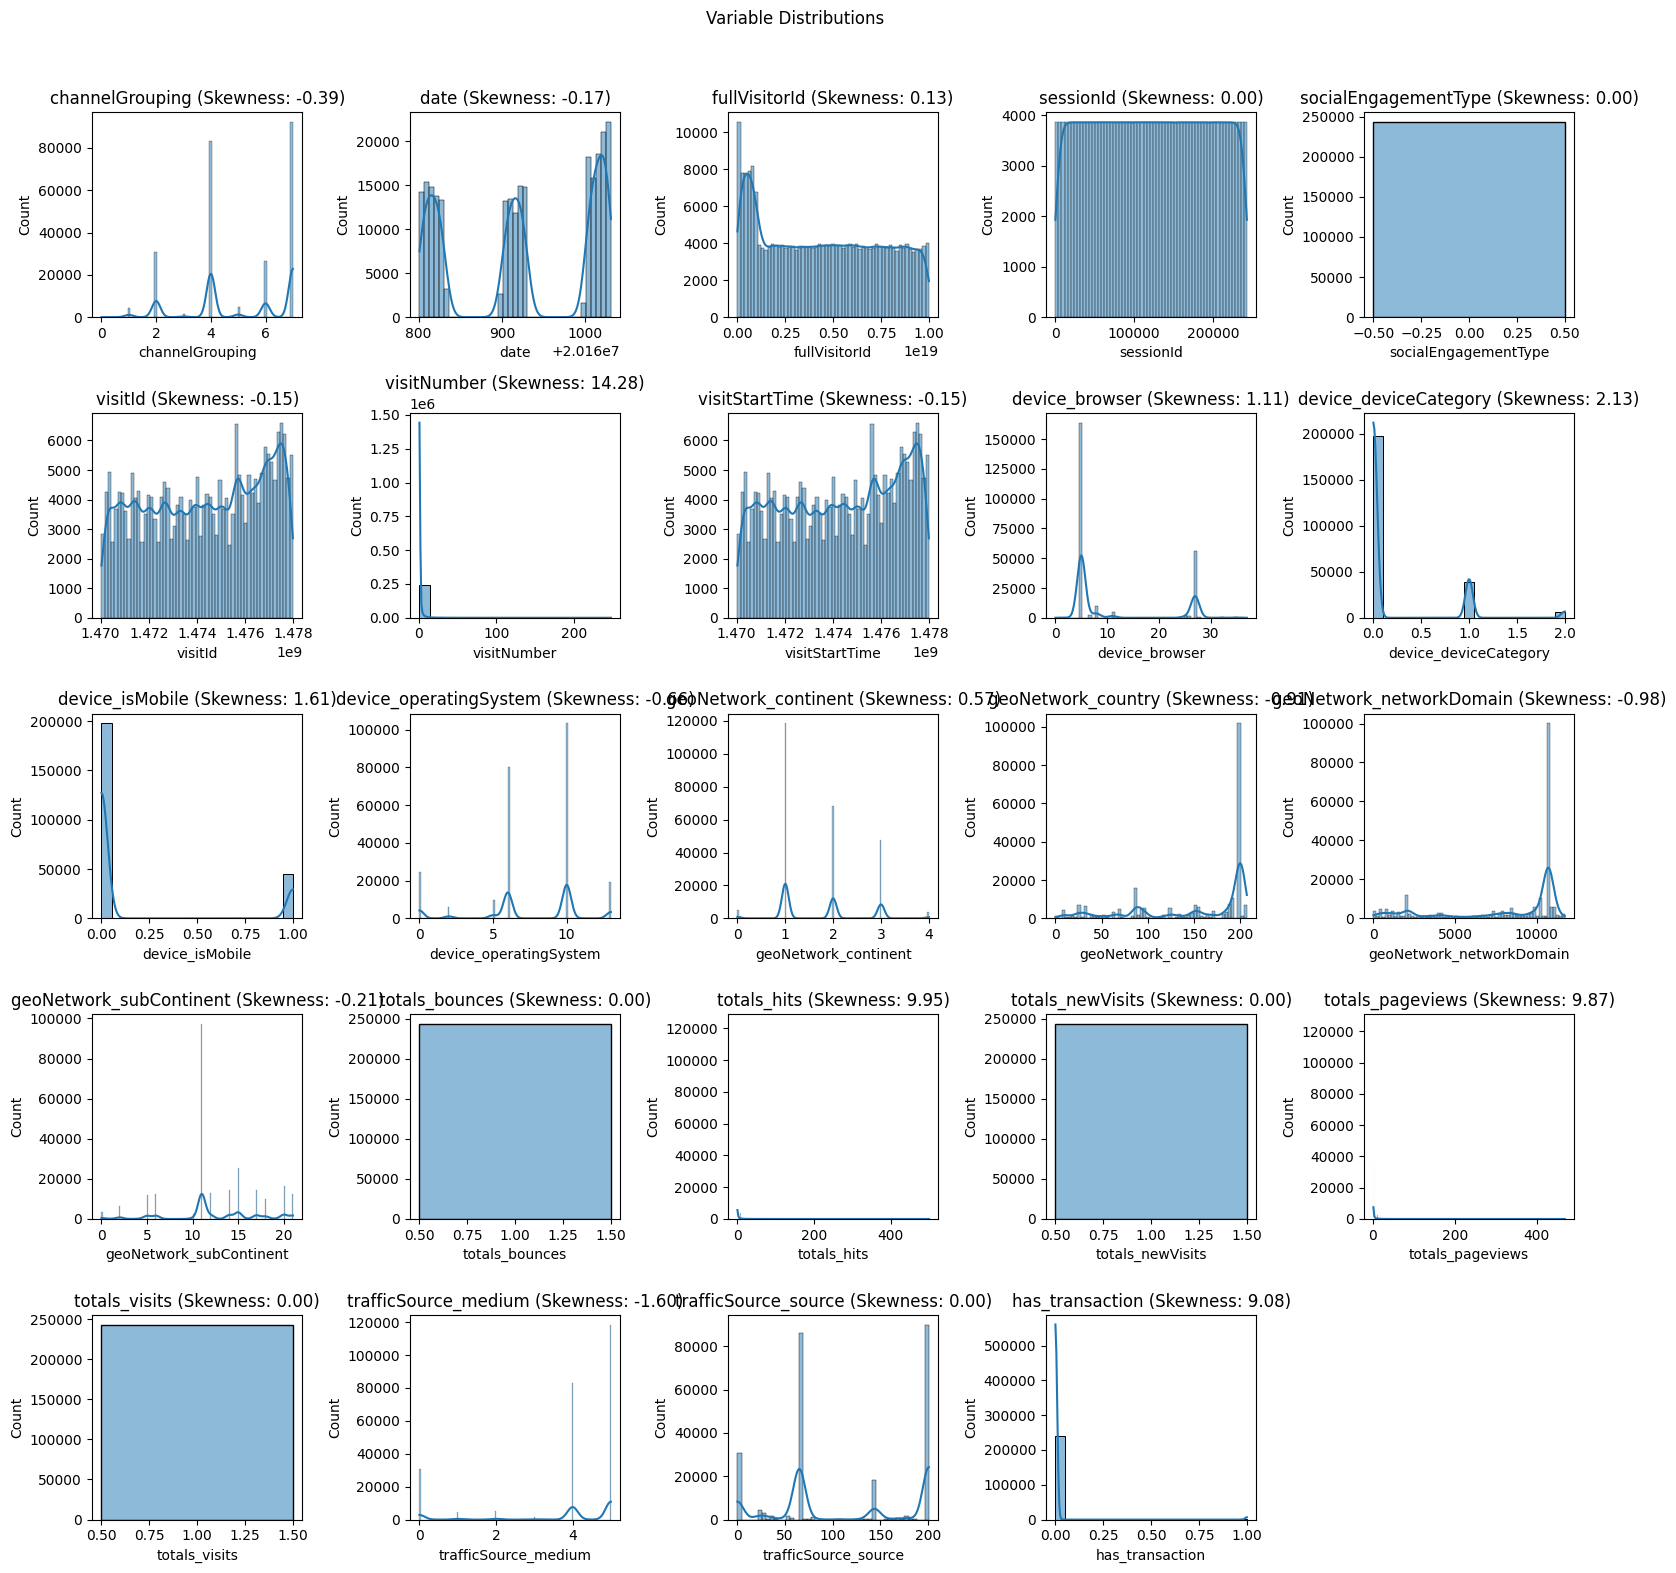

channelGrouping            -0.388
date                       -0.166
fullVisitorId               0.131
sessionId                   0.000
socialEngagementType        0.000
visitId                    -0.146
visitNumber                14.279
visitStartTime             -0.146
device_browser              1.107
device_deviceCategory       2.127
device_isMobile             1.606
device_operatingSystem     -0.661
geoNetwork_continent        0.573
geoNetwork_country         -0.907
geoNetwork_networkDomain   -0.977
geoNetwork_subContinent    -0.208
totals_bounces              0.000
totals_hits                 9.948
totals_newVisits            0.000
totals_pageviews            9.870
totals_visits               0.000
trafficSource_medium       -1.596
trafficSource_source        0.002
has_transaction             9.076
dtype: float64


In [ ]:
data=encoded_df
skewness = data.skew()

# Calculate the number of rows and columns for subplots
num_features = len(skewness)
num_rows = int(np.ceil(num_features ** 0.5))
num_cols = int(np.ceil(num_features / num_rows))

# Create subplots for each feature with square figure size
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(16, 16))
fig.suptitle('Variable Distributions')

# Flatten the axes for easier iteration
axes = axes.flatten()

# Plot histograms for each feature
for i, (feature, skew_val) in enumerate(skewness.items()):
    sns.histplot(data[feature], kde=True, ax=axes[i])
    axes[i].set_title(f'{feature} (Skewness: {skew_val:.2f})')

# Remove any unused subplots
for j in range(i + 1, num_rows * num_cols):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Show the plots
plt.show()
print(skewness)


**Observations:**

**High Negative Skewness (less than -1.0)** - The following variables exhibit high negative skewness (less than -1.0), indicating a heavily left-skewed distribution. Extreme values or outliers in these variables may disproportionately influence the logistic regression model:

* trafficSource_medium (-1.596)

**High Positive Skewness (greater than 1.0)** - The following variables display high positive skewness (greater than 1.0), indicating a heavily right-skewed distribution. This skewness can pose challenges for model interpretation and stability, particularly in logistic regression:

* visitNumber (14.279)
* totals_hits (9.948)
* totals_pageviews (9.870)




### 1.2. Multicolinearity of variables and their correlation with target variable

To build a regression model with the target variable "has_transaction" while addressing multicollinearity and focusing on the most relevant predictors, a subset of independent variables should be selected.

Since some of the columns (like 'totals_bounces and totals_newVisits') are containing constants they do not provide useful information for correlation analysis, as there is no variability in the data. Therefore to improve the efficiency and accuracy of analysis by focusing on relevant variables it was decided to remove them from data frame.

Dropped Constant Columns: ['socialEngagementType', 'totals_bounces', 'totals_newVisits', 'totals_visits']


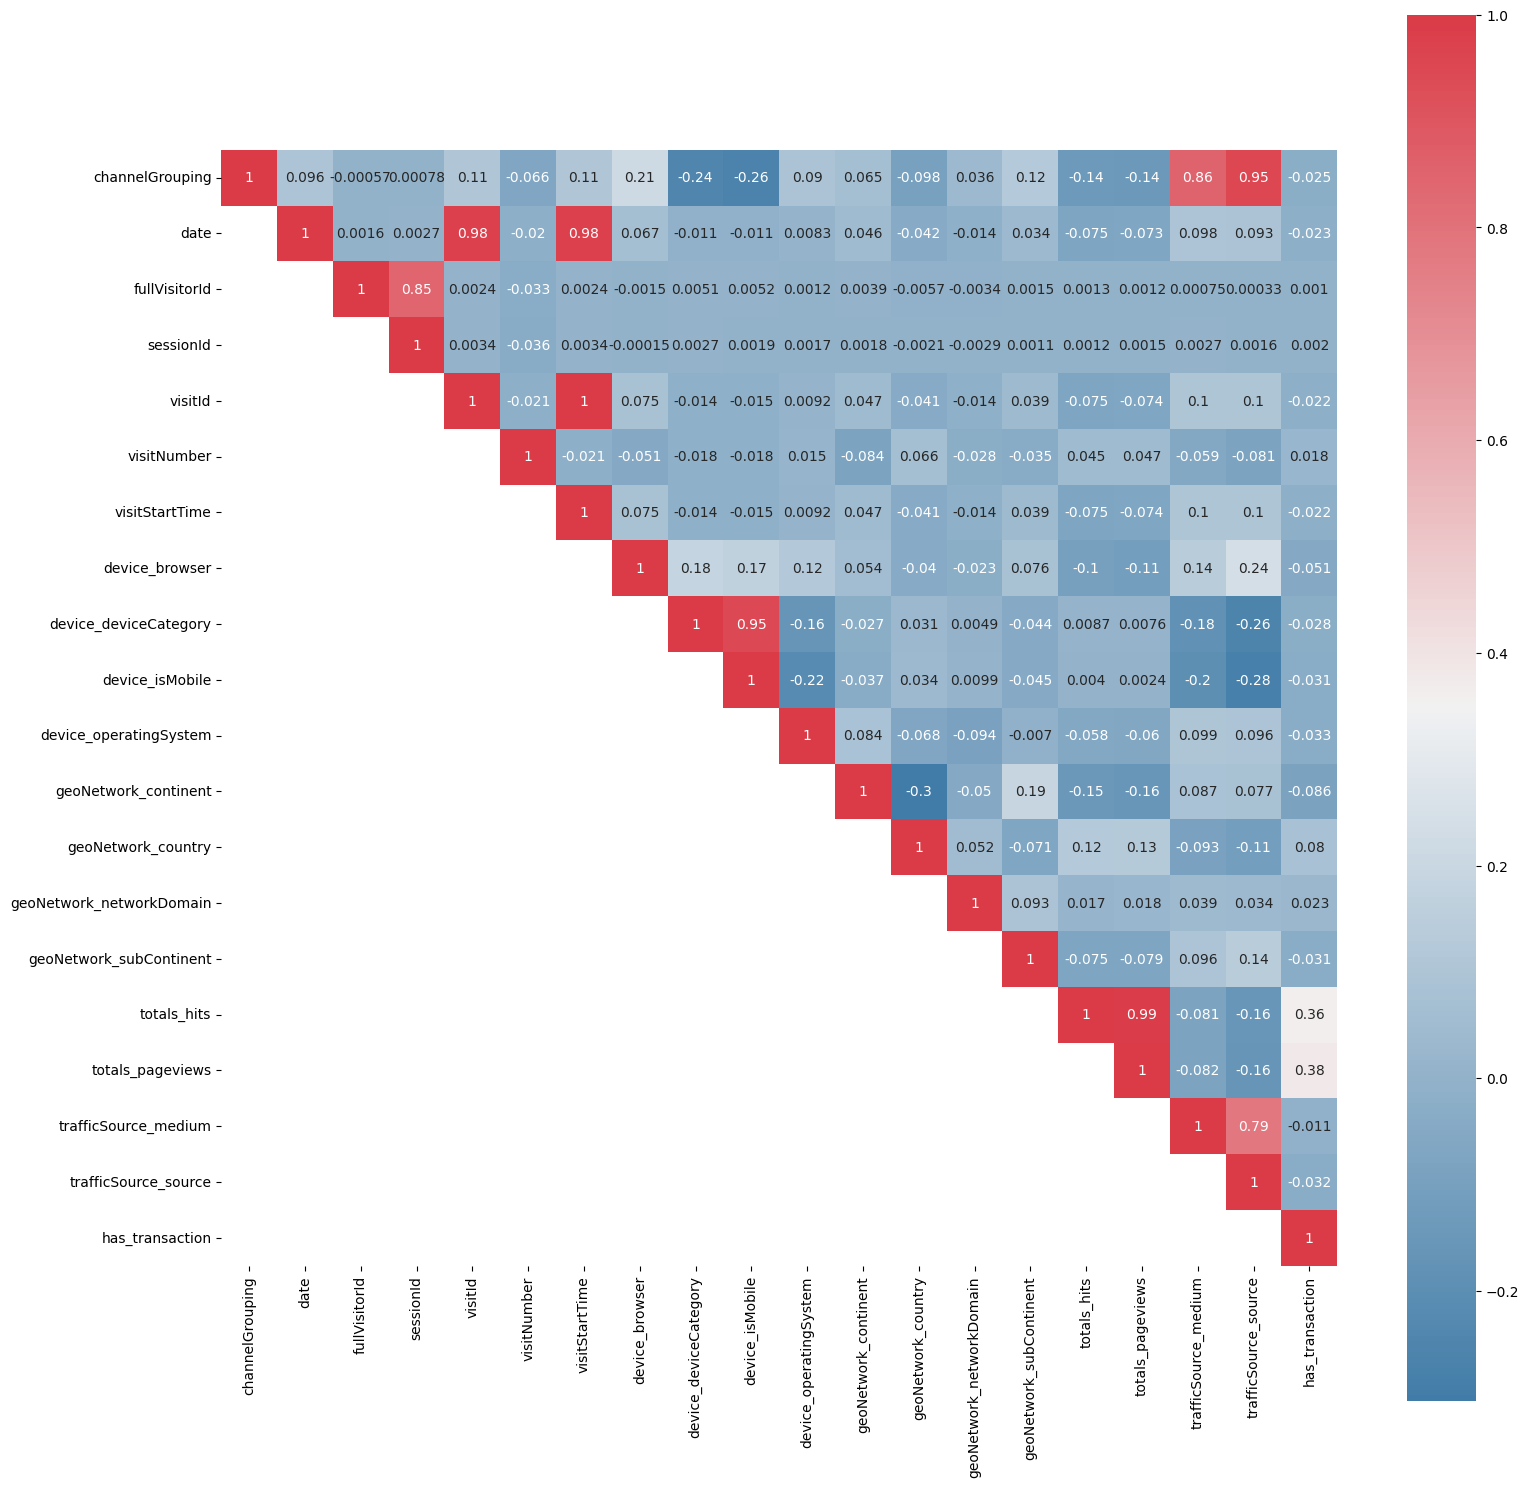

In [ ]:
# Create a copy of the DataFrame
data_copy = data.copy()

# Identify constant columns
constant_columns = [col for col in data_copy.columns if col != 'has_transaction' and data_copy[col].nunique() == 1]

# Print or store the list of dropped constant columns
print("Dropped Constant Columns:", constant_columns)

# Drop constant columns from the DataFrame
data = data_copy.drop(columns=constant_columns)

# Calculate the correlation matrix for the modified DataFrame
corr_train = data.corr()

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(18, 18))

# Draw the heatmap with the correct aspect ratio
sns.heatmap(corr_train, annot=True, cmap=sns.diverging_palette(240, 10, as_cmap=True),
            square=True, ax=ax, mask=np.tri(*corr_train.shape, dtype=bool, k=-1))

# Show the plot
plt.show()


In [ ]:
# Display the correlation values with the target variable
# Extract the correlations of features with the target variable
corr_with_target = corr_train['has_transaction'].sort_values(ascending=False)
print("Correlation with Target variable (Has transaction):")
print(corr_with_target)

Correlation with Target variable (Has transaction):
has_transaction             1.000
totals_pageviews            0.381
totals_hits                 0.359
geoNetwork_country          0.080
geoNetwork_networkDomain    0.023
visitNumber                 0.018
sessionId                   0.002
fullVisitorId               0.001
trafficSource_medium       -0.011
visitStartTime             -0.022
visitId                    -0.022
date                       -0.023
channelGrouping            -0.025
device_deviceCategory      -0.028
device_isMobile            -0.031
geoNetwork_subContinent    -0.031
trafficSource_source       -0.032
device_operatingSystem     -0.033
device_browser             -0.051
geoNetwork_continent       -0.086
Name: has_transaction, dtype: float64


Based on the provided correlation data and considering multicollinearity, the following variables should be included into regression model:

* totals_pageviews: This variable has a positive correlation of approximately 0.381 with the target variable "Has transaction." This suggests that as the number of page views increases, the likelihood of a transaction also increases.

* totals_hits: Similar to "totals_pageviews," this variable also has a positive correlation (around 0.359) with the target variable. It indicates that as the number of hits on the website increases, so does the likelihood of a transaction.

* visitNumber, date, channelGrouping, device_deviceCategory, device_browser, geoNetwork_continent: These variables have very weak correlations (close to 0) with the target variable. This suggests that they have little predictive power on whether a transaction occurs.

The highest correlation coefficient available between any pair of independent variables are approximately:

* date, visitId, and visitStartTime shows very high multicollinearity (1 and 0,98)
* totals_hits and totals_pageviews (0,99)
* channelGrouping, trafficSource_source (0,95) and trafficSource_medium (0,86)
* device_deviceCategory and device_isMobile (0,95)

Those variables is not recommended to use together in the regression model. Therefore only variables date, channelGrouping, total_pageviews are kept for further investigation (making a decision which variables to remove their skewness also was taken into account)

Correlation does not imply causation and it's important to keep in mind that other factors may also influence the probability of purchase.

In [ ]:
data_copy = data.copy()  # Create a copy of the DataFrame

# List of columns to drop
columns_to_drop = ['visitId', 'visitStartTime', 'totals_hits', 'trafficSource_source', 'trafficSource_medium', 'device_isMobile']

# Drop the specified columns from the copy of the DataFrame
data_copy.drop(columns=columns_to_drop, inplace=True)
data_cleaned=data_copy


### 1.3. Outliers

In order to estimate the outlier the IQR method was used to count percentage of outliers for X axis variables. Since fullVisitorId is a unique identifier for each visitor and does not represent a numerical or categorical variable therefore it was excluded from outliers analysis.

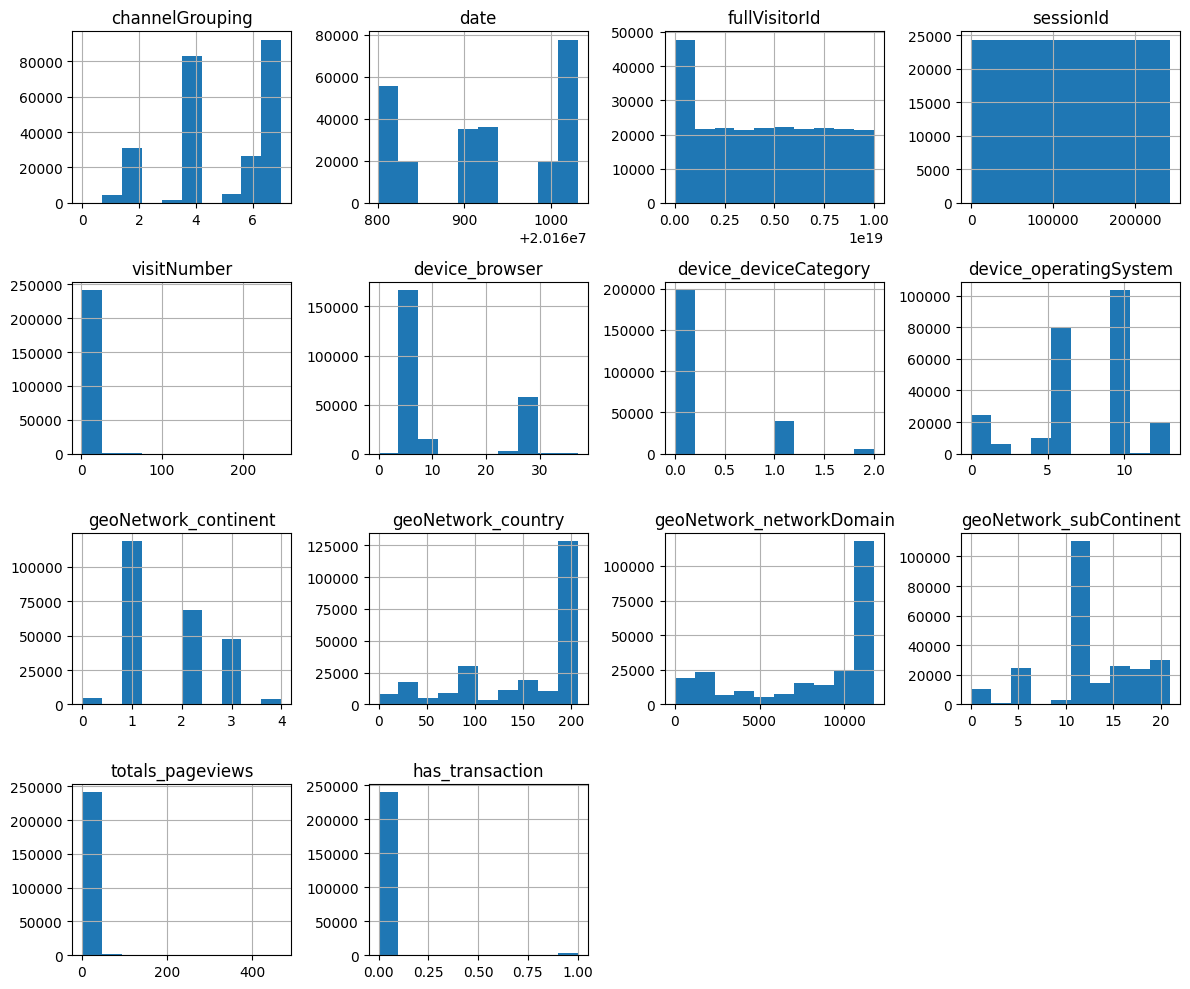

In [ ]:
# Create a boxplot for the remaining variables
data_cleaned.hist(figsize=(12, 10))
plt.tight_layout()
plt.show()

In [ ]:
data=data_cleaned
# calculating quartile range and IQR for all columns in data
for column in data.columns:
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1

    # calculating upper and lower limit
    lower_limit = Q1 - 1.5 * IQR
    upper_limit = Q3 + 1.5 * IQR

    # filtering to see the outliers
    outliers_upper = data[data[column] > upper_limit]
    outliers_lower = data[data[column] < lower_limit]

    # calculate percentage of outliers
    total_values = data[column].count()
    percentage_upper = ((outliers_upper.shape[0] + outliers_lower.shape[0]) / total_values) * 100

    print(f"Column: {column}")
    print(f"Lower limit: {lower_limit:.2f}")
    print(f"Upper limit: {upper_limit:.2f}")
    print(f"Number of outliers in the upper limit: {outliers_upper.shape[0]}")
    print(f"Number of outliers in the lower limit: {outliers_lower.shape[0]}")
    print(f"Total percentage of outliers: {percentage_upper:.2f}%\n")

Column: channelGrouping
Lower limit: -0.50
Upper limit: 11.50
Number of outliers in the upper limit: 0
Number of outliers in the lower limit: 0
Total percentage of outliers: 0.00%

Column: date
Lower limit: 20160544.00
Upper limit: 20161296.00
Number of outliers in the upper limit: 0
Number of outliers in the lower limit: 0
Total percentage of outliers: 0.00%

Column: fullVisitorId
Lower limit: -6744635775505653760.00
Upper limit: 15534091679996190720.00
Number of outliers in the upper limit: 0
Number of outliers in the lower limit: 0
Total percentage of outliers: 0.00%

Column: sessionId
Lower limit: -121508.50
Upper limit: 364551.50
Number of outliers in the upper limit: 0
Number of outliers in the lower limit: 0
Total percentage of outliers: 0.00%

Column: visitNumber
Lower limit: 1.00
Upper limit: 1.00
Number of outliers in the upper limit: 48105
Number of outliers in the lower limit: 0
Total percentage of outliers: 19.77%

Column: device_browser
Lower limit: -25.00
Upper limit: 55

**High Outlier Percentage (Over 10%)**  - indicating significant variability in visit counts, device types and engagement-related data within the dataset:
* visitNumber - 19.77%
* device_deviceCategory - 18.69%
* totals_pageviews - 12.10%

**Moderate Outlier Percentage (Between 5% and 15%)** - suggesting notable variations in terms of subcontinental data:
* geoNetwork_subContinent - 4.78%


**Low Outlier Percentage (Between 1% and 5%)** exhibit a relatively lower percentage of outliers, indicating less pronounced deviations from the norm in terms of continental data:
* geoNetwork_continent - 1.52%

Most of the outliers represent genuine, albeit extreme, observations in the dataset. They could be indicative of rare events, unique behaviors, or unusual circumstances that reflect real-world scenarios.  

Let's explore why these distributions might reflect real-life scenarios:

**visitNumber (19.77%)**: The high percentage of outliers in visitNumber could indicate that a substantial portion of the visits are from a relatively small number of users who make a very large number of visits. This pattern is not uncommon in web traffic data, where power users or bots might account for a disproportionately high number of visits compared to the average user.

**device_deviceCategory (18.69%)**: The outlier percentage in device_deviceCategory suggests a significant variation in the types of devices used to access the website or app. For example, a high percentage of outliers could indicate an unusual prevalence of visits from less common device categories (e.g., gaming consoles, smart TVs) compared to the dominant categories (desktop, mobile, tablet). This insight is valuable for optimizing user experience across different device types.

**totals_pageviews (12.10%):** The presence of outliers in totals_pageviews likely reflects diverse user behaviors, where certain sessions result in an unusually high number of pageviews.

In the columns with percentage of outliers more than 5% they were replaced by median

## 2. Model Creation

To create a logistic regression model the data will be splitted into training and test datasets. For logistic regression model estimation 2 training dataset options will be investigated - with and without outliers

In [ ]:
#Splitting data into training and test datasets

x = data.drop(columns='has_transaction', axis=1)
y = data['has_transaction']

# Split the dataset into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify= y)

# Display the shapes of the resulting datasets to verify the split
print("Training set shape:", x_train.shape, y_train.shape)
print("Test set shape:", x_test.shape, y_test.shape)

Training set shape: (194637, 13) (194637,)
Test set shape: (48660, 13) (48660,)


###2.3 Logistic Regression Model

In [ ]:
# Check for zero variance columns
zero_variance_cols = data.columns[data.nunique() == 1]
data.drop(columns=zero_variance_cols, inplace=True)

# Separate target variable (y_train) from features (x_train)
y_train = data['has_transaction']
x_train = data.drop(columns=['has_transaction'])

# Scale the data and preserve column names
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_train_scaled = pd.DataFrame(x_train_scaled, columns=x_train.columns)  # Assuming you're using pandas DataFrame

# Add a constant term to the features matrix for statsmodels
x_train_with_const = sm.add_constant(x_train_scaled)

# Reset the index of y_train to match x_train_with_const
y_train.reset_index(drop=True, inplace=True)

# Fit logistic regression model using statsmodels
logit_model = sm.Logit(y_train, x_train_with_const)
logit_result = logit_model.fit()

# Extract p-values from the result
p_values = logit_result.pvalues

# Display summary results
print(logit_result.summary())

Optimization terminated successfully.
         Current function value: 0.040968
         Iterations 12
                           Logit Regression Results                           
Dep. Variable:        has_transaction   No. Observations:               243297
Model:                          Logit   Df Residuals:                   243283
Method:                           MLE   Df Model:                           13
Date:                Thu, 09 May 2024   Pseudo R-squ.:                  0.3572
Time:                        12:49:34   Log-Likelihood:                -9967.5
converged:                       True   LL-Null:                       -15507.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       -6.5813      0.075    -87.662      0.000      -6.72

Positive coefficients suggest a positive correlation with the likelihood of purhase and vice versa.

The pseudo R-squared value of approximately 0.3572 suggests that the model explains approximately 35.72% of the variability in the dependent variable.

**Choosing variables for the model**<br>
Regression analysis shows that some variable are nor statistically significant therefore only variables with p-values less than 0,05 are considered to choose.

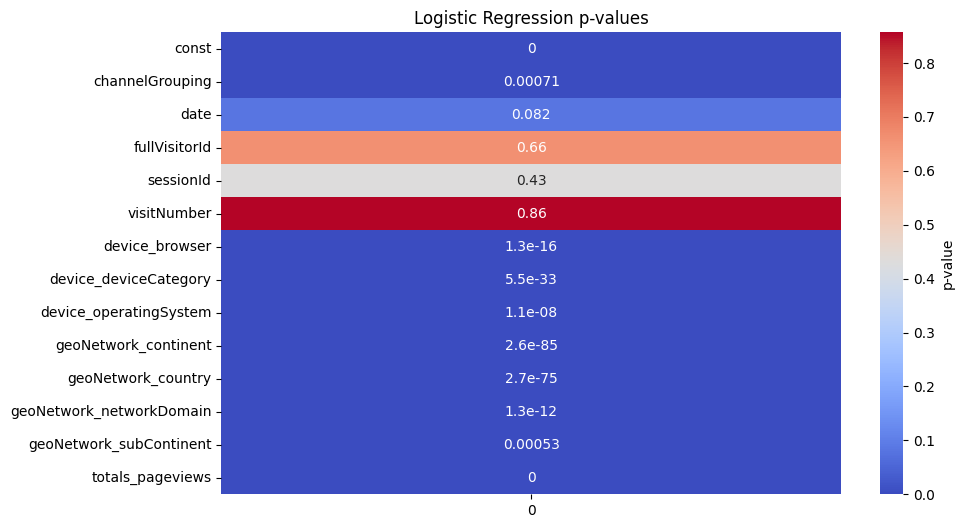

In [ ]:
# Plot heatmap of p-values
plt.figure(figsize=(10, 6))
sns.heatmap(p_values.to_frame(), annot=True, cmap="coolwarm", cbar_kws={'label': 'p-value'})
plt.title("Logistic Regression p-values")
plt.show()

For further probability of default model creation and investigation of significant factors only significant columns will be used

In [ ]:
# Function for backward elimination
def backward_elimination(x_train, y_train, threshold=0.05):

    # Fit the logistic regression model
    logit_model = sm.Logit(y_train, x_train)
    logit_result = logit_model.fit()

    # Iteratively remove attributes with high p-values
    while True:
        # Find the attribute with the highest p-value
        max_p_value = logit_result.pvalues.max()

        # If the highest p-value is above the threshold, remove the corresponding attribute
        if max_p_value > threshold:
            max_p_index = logit_result.pvalues.idxmax()
            x_train = x_train.drop(max_p_index, axis=1)
            print(f"\nRemoving '{max_p_index}' (p-value: {max_p_value})")
            logit_model = sm.Logit(y_train, x_train)
            logit_result = logit_model.fit()
        else:
            break

    return logit_result

# Call the backward elimination function
final_logit_result = backward_elimination(x_train, y_train)

# Extract p-values from the result
p_values_significant = final_logit_result.pvalues

# Get the AIC value
aic = round((final_logit_result.aic),2)

# Print the final summary of the model results
print("\nFinal Model Summary:")
print(final_logit_result.summary())
print("AIC:", aic)

Optimization terminated successfully.
         Current function value: 0.040975
         Iterations 11

Removing 'visitNumber' (p-value: 0.8372116357344765)
Optimization terminated successfully.
         Current function value: 0.040975
         Iterations 11

Removing 'fullVisitorId' (p-value: 0.6635467022027639)
Optimization terminated successfully.
         Current function value: 0.040975
         Iterations 11

Removing 'sessionId' (p-value: 0.43780053994128443)
Optimization terminated successfully.
         Current function value: 0.040976
         Iterations 11

Final Model Summary:
                           Logit Regression Results                           
Dep. Variable:        has_transaction   No. Observations:               243297
Model:                          Logit   Df Residuals:                   243287
Method:                           MLE   Df Model:                            9
Date:                Thu, 09 May 2024   Pseudo R-squ.:                  0.3571
Time:   

Checking P-values for selected features

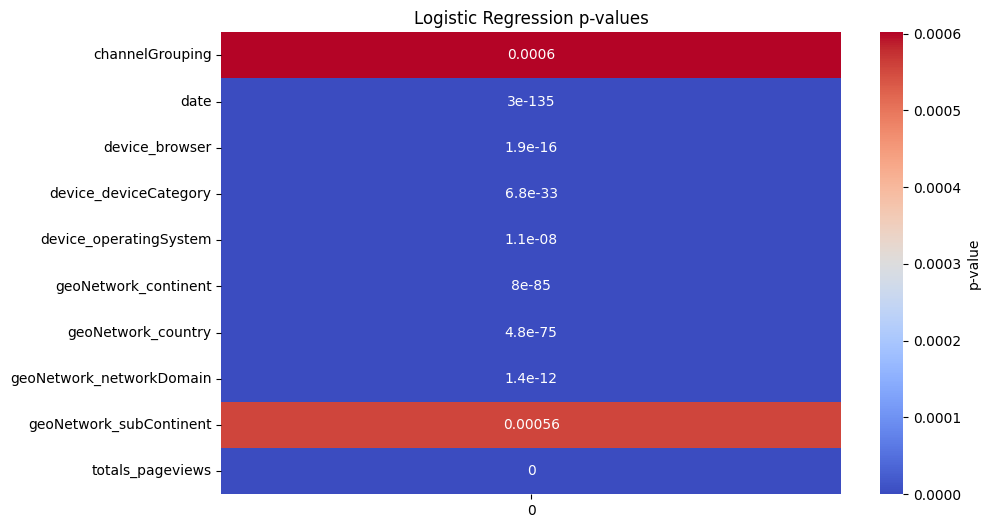

In [ ]:
# Plot heatmap of p-values
plt.figure(figsize=(10, 6))
sns.heatmap(p_values_significant.to_frame(), annot=True, cmap="coolwarm", cbar_kws={'label': 'p-value'})
plt.title("Logistic Regression p-values")
plt.show()

##3. Model Application in Practice

### 3.1. Model performance metrics

In [ ]:
# List of significant columns
significant_columns = ['channelGrouping', 'device_browser', 'geoNetwork_continent',
    'date', 'geoNetwork_country', 'device_deviceCategory', 'device_operatingSystem',
    'geoNetwork_networkDomain', 'geoNetwork_subContinent', 'totals_pageviews']

# Extract only the significant columns from the test dataset
x_train_significant = x_train[significant_columns]

# Standardize the data
scaler = StandardScaler()
x_train_significant_scaled = scaler.fit_transform(x_train_significant)

# Create a logistic regression model with increased max_iter
reg = LogisticRegression(max_iter=100000)
reg.fit(x_train_significant_scaled, y_train)

# Predictions on the test set using significant columns
y_pred_significant = reg.predict(x_train_significant_scaled)

# Probabilities for class 1 (Purchase) using significant columns
probabilities_significant = reg.predict_proba(x_train_significant_scaled)[:, 1]

# Coefficients and intercept
coefficients = reg.coef_[0]
intercept = reg.intercept_[0]

# Calculate metrics
accuracy_train = round((accuracy_score(y_train, y_pred_significant)*100),2)
precision_train = round((precision_score(y_train, y_pred_significant)*100),2)
recall_train =  round((recall_score(y_train, y_pred_significant)*100),2)
f1 = f1_score(y_train, y_pred_significant)
roc_auc = roc_auc_score(y_train, probabilities_significant)

# Calculate confusion matrix
conf_matrix_train = confusion_matrix(y_train, y_pred_significant)

# Print the confusion matrix
print("Confusion Matrix (Training Set):")
print(conf_matrix_train)

print("Performance Metrics (Training Set):")
print("Accuracy:", accuracy_train, "%")
print("Precision:", precision_train, "%")
print("Recall:", recall_train, "%")




Confusion Matrix (Training Set):
[[240013    434]
 [  2516    334]]
Performance Metrics (Training Set):
Accuracy: 98.79 %
Precision: 43.49 %
Recall: 11.72 %


**Accuracy:** Accuracy measures the overall correctness of the predictions, representing the proportion of correctly classified cases among all cases. In this case Accuracy: 98.76%

**Precision:** Precision measures the proportion of correctly identified positive cases among all cases identified as positive. In other words - the ratio of non-transacted customers predicted as such. Precision: 42.76%

**Recall:** Recall measures the proportion of correctly identified positive cases among all actual positive cases, indicating the model's ability to find all cases with transacted customers. Recall: 11.3%

### 3.2. Model's Threshold

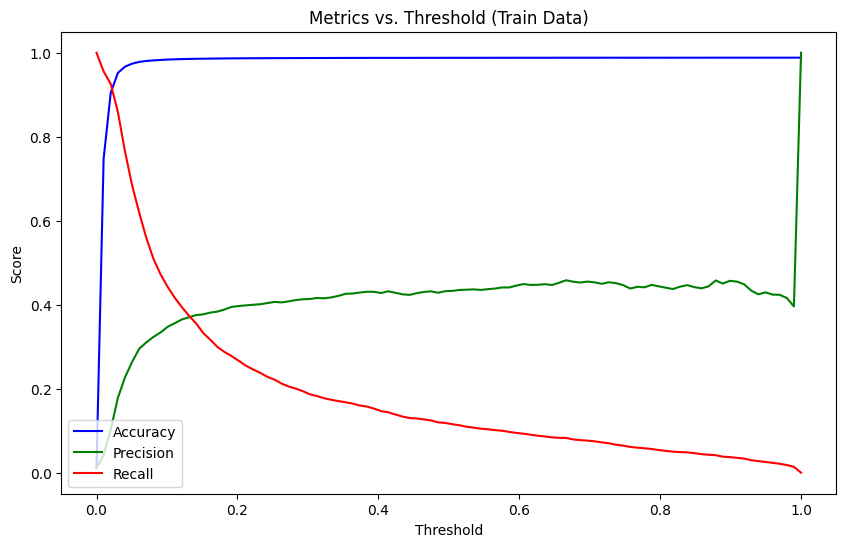

In [ ]:
# Define thresholds
thresholds = np.linspace(0, 1, 100)

# Lists to store prediction metrics
accuracy_scores = []
precision_scores = []
recall_scores = []

# Calculate metric scores for each threshold
for threshold in thresholds:
    # Apply threshold to predicted probabilities
    predicted_classes_train = (logit_result.predict(x_train_with_const) > threshold).astype(int)

    # Calculate accuracy, precision, and recall scores
    accuracy_train = accuracy_score(y_train, predicted_classes_train)
    precision_train = precision_score(y_train, predicted_classes_train, zero_division=1)
    recall_train = recall_score(y_train, predicted_classes_train)

    # Append scores to lists
    accuracy_scores.append(accuracy_train)
    precision_scores.append(precision_train)
    recall_scores.append(recall_train)

# Plot graphs
plt.figure(figsize=(10, 6))

plt.plot(thresholds, accuracy_scores, label='Accuracy', color='blue')
plt.plot(thresholds, precision_scores, label='Precision', color='green')
plt.plot(thresholds, recall_scores, label='Recall', color='red')

plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Metrics vs. Threshold (Train Data)')
plt.legend(facecolor='white')
plt.show()

In this case, the cut-off was selected to prioritize reducing false negatives, as it's more critical to identify as many purchases that will occur as possible. For this reason, a new cut-off of 0.15 was chosen.

**Confusion matrix with 0.15 probability cut-off**

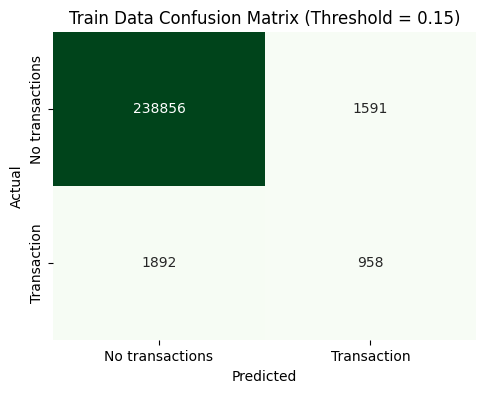

True Positives (TP): 958
False Positives (FP): 1591
True Negatives (TN): 238856
False Negatives (FN): 1892

True Positive Rate (Sensitivity/Recall): 0.3361
False Positive Rate: 0.0066


In [ ]:
threshold = 0.15

# Predict classes
predicted_probabilities_train = logit_result.predict(x_train_with_const)
predicted_classes_train = (predicted_probabilities_train > threshold).astype(int)

# Calculate confusion matrix
conf_matrix_train = confusion_matrix(y_train, predicted_classes_train)

# Plot confusion matrices
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
sns.heatmap(conf_matrix_train, annot=True, fmt='d', cmap='Greens', cbar=False,
            xticklabels=["No transactions", "Transaction"],
            yticklabels=["No transactions", "Transaction"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Train Data Confusion Matrix (Threshold = 0.15)')
plt.show()

# Extract TP, FP, TN, FN from the confusion matrix
TP = conf_matrix_train[1, 1]
FP = conf_matrix_train[0, 1]
TN = conf_matrix_train[0, 0]
FN = conf_matrix_train[1, 0]

# Display TP, FP, TN, FN
print(f"True Positives (TP): {TP}")
print(f"False Positives (FP): {FP}")
print(f"True Negatives (TN): {TN}")
print(f"False Negatives (FN): {FN}")

# Calculate True Positive Rate (Sensitivity/Recall)
TPR = TP / (TP + FN)
print(f"\nTrue Positive Rate (Sensitivity/Recall): {TPR:.4f}")

# Calculate False Positive Rate
FPR = FP / (FP + TN)
print(f"False Positive Rate: {FPR:.4f}")



In [ ]:
# Calculate precision, accuracy, and recall for training set
precision_train = round(precision_score(y_train, predicted_classes_train),4)*100
accuracy_train = round(accuracy_score(y_train, predicted_classes_train),4)*100
recall_train = round(recall_score(y_train, predicted_classes_train),4)*100

# Create a DataFrame to display the evaluation metrics
evaluation_metrics = pd.DataFrame({
    'Metric': ['Precision, %', 'Accuracy, %', 'Recall, %'],
    'Train Data': [precision_train, accuracy_train, recall_train],

})

# Display the DataFrame
print(evaluation_metrics)

         Metric  Train Data
0  Precision, %      37.580
1   Accuracy, %      98.570
2     Recall, %      33.610


### 3.3. ROC Curve  and AUC

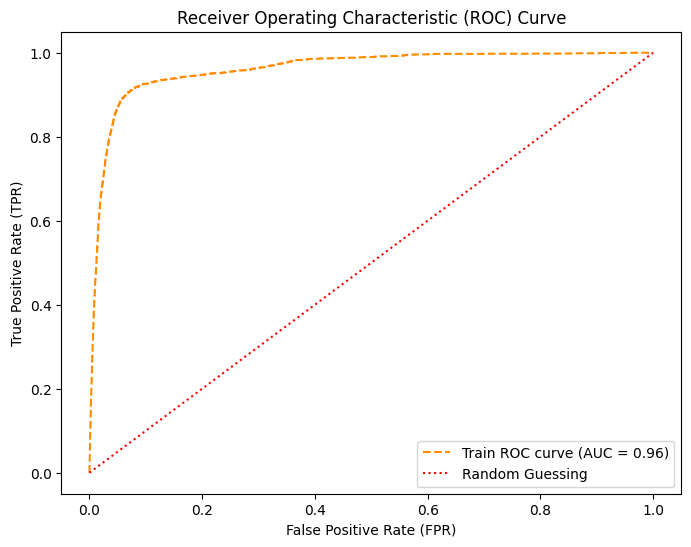

In [ ]:
#train ROC curve
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, predicted_probabilities_train)
roc_auc_train = auc(fpr_train, tpr_train)

# Plot ROC curves
plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, color='darkorange', linestyle='--', label='Train ROC curve (AUC = {:.2f})'.format(roc_auc_train))
plt.plot([0, 1], [0, 1], color='red', linestyle=':', label='Random Guessing')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(facecolor='white')
plt.show()

The ROC curve is similar to the performance metrics. With model performing slightly less well on the test data, but still with AUC 0.96 it is better than random guess.

### 3.4. Probability of purchase

In [ ]:
# Display coefficients
print("Coefficients:")
for feature, coef in zip(significant_columns, coefficients):
    print(f"{feature}: {coef:.4f}")

# Display intercept
print(f"\nIntercept: {intercept:.4f}")

# Display odds
print("\nOdds:")
for feature, odd in zip(significant_columns, np.exp(coefficients)):
    print(f"{feature}: {odd:.4f}")

# Display probabilities
print("\nProbabilities:")
for feature, prob in zip(significant_columns, probabilities_significant):
    print(f"{feature}: {prob:.4f}")


Coefficients:
channelGrouping: 0.0862
device_browser: -0.3293
geoNetwork_continent: -1.2131
date: 0.0383
geoNetwork_country: 1.2832
device_deviceCategory: -0.4349
device_operatingSystem: -0.1590
geoNetwork_networkDomain: 0.1767
geoNetwork_subContinent: -0.2016
totals_pageviews: 0.6649

Intercept: -6.5733

Odds:
channelGrouping: 1.0900
device_browser: 0.7194
geoNetwork_continent: 0.2973
date: 1.0391
geoNetwork_country: 3.6083
device_deviceCategory: 0.6473
device_operatingSystem: 0.8530
geoNetwork_networkDomain: 1.1933
geoNetwork_subContinent: 0.8175
totals_pageviews: 1.9443

Probabilities:
channelGrouping: 0.0095
device_browser: 0.0001
geoNetwork_continent: 0.0001
date: 0.0002
geoNetwork_country: 0.0020
device_deviceCategory: 0.0002
device_operatingSystem: 0.0001
geoNetwork_networkDomain: 0.0002
geoNetwork_subContinent: 0.0004
totals_pageviews: 0.0001


Probability of purchase by significant variables

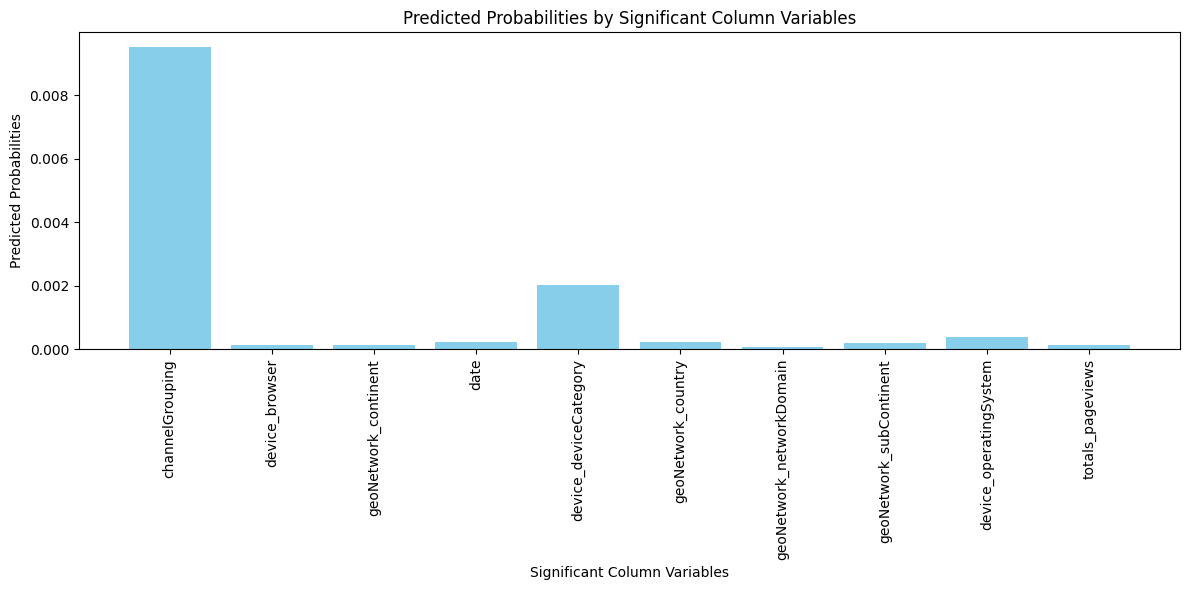

In [ ]:
# Data
significant_columns = [
    'channelGrouping', 'device_browser', 'geoNetwork_continent',
    'date', 'device_deviceCategory', 'geoNetwork_country',
    'geoNetwork_networkDomain', 'geoNetwork_subContinent',
    'device_operatingSystem', 'totals_pageviews'
]

# Plotting
plt.figure(figsize=(12, 6))

# Create a bar plot using zip to iterate over columns and probabilities
for feature, prob in zip(significant_columns, probabilities_significant):
    plt.bar(feature, prob, color='skyblue')

# Rotate x-axis labels for better readability
plt.xticks(rotation=90)

# Add labels and title
plt.xlabel('Significant Column Variables')
plt.ylabel('Predicted Probabilities')
plt.title('Predicted Probabilities by Significant Column Variables')

# Show plot
plt.tight_layout()
plt.show()

## 4. Insights and recommendations

**Precision:** The precision rate of 37.58% indicates that approximately 37.58% of the positive predictions made by the model are correct. This precision value represents an improvement compared to previous data, although it still suggests that there is room for enhancing the accuracy of positive predictions.

**Accuracy:** The accuracy rate of 98.57% remains high, indicating that the majority of the model's predictions across both positive and negative classes are correct. This reflects a strong overall performance of the model in making accurate predictions.

**Recall (Sensitivity):** The recall rate has notably increased to 33.6%, indicating that the model is now better at identifying a larger proportion of the actual positive instances in the dataset compared to previous assessments. This improvement suggests progress in the model's ability to capture positive cases.

**True Positive Rate (TPR):** The true positive rate (sensitivity/recall) of 33.61% aligns with the recall percentage, representing the proportion of true positive predictions relative to all actual positive instances. This metric has shown improvement, indicating that the model's capability to identify positive instances has strengthened.

**False Positive Rate (FPR):** The false positive rate of 0.6% (or 0.006) signifies the proportion of negative instances that were incorrectly classified as positive by the model. This rate remains relatively low, which is a positive indicator of the model's ability to minimize false positives.


To address the low recall rate, similar strategies as previously mentioned should be considered, such as data balancing techniques to ensure a more balanced representation of positive and negative instances during model training. Additionally, further refinement of the model's parameters and feature selection could help enhance its ability to accurately identify positive instances.

Despite the high accuracy and improved recall rate, there is still potential for further optimization. Monitoring false positives and continuing to refine the model's parameters and feature selection can help enhance its precision and overall performance. Additionally, evaluating the impact of class imbalance and considering data balancing techniques could contribute to more balanced and reliable predictions.